In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader

In [2]:
df = pd.read_csv(r"C:\Users\admin\Desktop\week_of_data4_headFlaw.csv",encoding='utf-8',header=None)
df.head(10)

,0,1,2,3
0,2015/5/20 0:00,263,240,2015/5/20
1,2015/5/20 0:05,263,234,2015/5/20
2,2015/5/20 0:10,263,228,2015/5/20
3,2015/5/20 0:15,263,227,2015/5/20
4,2015/5/20 0:20,263,228,2015/5/20
5,2015/5/20 0:25,263,226,2015/5/20
6,2015/5/20 0:30,263,224,2015/5/20
7,2015/5/20 0:35,263,219,2015/5/20
8,2015/5/20 0:40,263,213,2015/5/20
9,2015/5/20 0:45,263,205,2015/5/20


In [3]:
df.columns = ['time','id','gl', 'date']
df = df[['time','id','gl']]
df.head()

,time,id,gl
0,2015/5/20 0:00,263,240
1,2015/5/20 0:05,263,234
2,2015/5/20 0:10,263,228
3,2015/5/20 0:15,263,227
4,2015/5/20 0:20,263,228


In [4]:
ID = df['id'].value_counts().index
pd.set_option('display.max_rows',100)
print(ID)
print(len(ID))

Index([263, 106, 185, 218,  74,  53, 216, 219, 113,  47,  14, 134,  37,  61,
        46,  33,  54, 278, 136, 274,   9, 265, 283, 273, 119, 129,  32,  27,
       236,  26, 206,  18, 165,  31,  24, 267,  22, 247, 124,  79, 258,  58,
       234, 175, 156, 158, 188, 189, 201, 203,  77, 127,  67,  70, 102, 137,
         7,  95, 232,  23, 271, 130,  68, 227, 228, 164, 111, 251, 155, 245,
       229, 277, 193, 101, 269,   3, 250, 116, 109,  81,  65, 184, 146, 105,
       138,  76, 198, 139, 214, 166, 135, 123, 253, 187,  17, 205, 220, 243,
       281],
      dtype='int64', name='id')
99


In [5]:
#获取数据

# 创建空的DataFrame
total_data = {'id': [],'month':[],'day':[],'hour':[],'minute':[],'weekday':[],'gl': []}
total_data = pd.DataFrame(total_data)

for i in ID:
    print("开始获取id为{}的被试数据：---------------------------------".format(i))
    data = df[df['id']== i].copy() 
    print(data.shape)
    #将time列设成date数据类型
    data['time'] = pd.to_datetime(data['time'])

    #按照时间排序
    data = data.sort_values(by='time') 

    #提取月为单独的一列
    data['month'] = data['time'].dt.month

    #提取日为单独的一列
    data['day'] = data['time'].dt.day

    #提取小时为单独的一列
    data['hour'] = data['time'].dt.hour

    #提取分钟为单独的一列
    data['minute'] = data['time'].dt.minute

    # 提取周几（0表示星期一，1表示星期二，依此类推）
    data['weekday'] = data['time'].dt.dayofweek

    #设置时间为行索引
    data = data.set_index('time')

    data = data.astype(np.float32) # 修改数据类型
    
    #整合全部数据
    total_data = pd.concat([total_data, data], ignore_index=True)
    break

开始获取id为263的被试数据：---------------------------------
(2016, 3)


In [6]:
total_data

,id,month,day,hour,minute,weekday,gl
0,263.0,5.0,20.0,0.0,0.0,2.0,240.0
1,263.0,5.0,20.0,0.0,5.0,2.0,234.0
2,263.0,5.0,20.0,0.0,10.0,2.0,228.0
3,263.0,5.0,20.0,0.0,15.0,2.0,227.0
4,263.0,5.0,20.0,0.0,20.0,2.0,228.0
...,...,...,...,...,...,...,...
2011,263.0,5.0,26.0,23.0,38.0,1.0,152.0
2012,263.0,5.0,26.0,23.0,43.0,1.0,160.0
2013,263.0,5.0,26.0,23.0,48.0,1.0,166.0
2014,263.0,5.0,26.0,23.0,53.0,1.0,173.0


In [7]:
#窗口划分
# 创建一个空的三维数组
seq = 48
train_total_feats = np.empty((0, seq, 7))
train_total_targets = np.empty((0,7))

test_total_feats = np.empty((0, seq, 7))
test_total_targets = np.empty((0, 7))

# 设每条数据序列有48组数据

for i in ID:
    data = total_data[total_data['id'] == i]
    print("当前被试(id == {})的数据集长度：".format(i),data.shape)
    
    # 创建两个列表，用来存储当前被试的数据特征和标签
    one_feats = np.empty((0, seq, 7))
    one_targets = np.empty((0,7))
    for index in range(len(data) - seq):
        # 构建特征集
        one_feats = np.concatenate((one_feats, data[index: index + seq].values.reshape(-1,seq,7)), axis=0)
        # 构建target集
        one_targets = np.concatenate((one_targets, data.iloc[index + seq].values.reshape(1,-1)), axis=0)
        
    #划分每个被试的训练集和测试集
    test_size = int(np.round(0.2 * one_feats.shape[0]))  # np.round(1)是四舍五入，
    train_size = one_feats.shape[0] - test_size 
    
    train_total_feats = np.concatenate((train_total_feats, one_feats[:train_size, :, :]), axis=0)
    train_total_targets = np.concatenate((train_total_targets, one_targets[:train_size,:]), axis=0)
    test_total_feats = np.concatenate((test_total_feats, one_feats[train_size:, :, :]), axis=0)
    test_total_targets = np.concatenate((test_total_targets, one_targets[train_size:, :]), axis=0)
    break

当前被试(id == 263)的数据集长度： (2016, 7)


In [8]:
# 将变量保存到文件，以便下次直接读取，不用在处理数据
np.save('./variable_file/train_total_feats_1.npy',train_total_feats)
np.save('./variable_file/train_total_targets_1.npy',train_total_targets)
np.save('./variable_file/test_total_feats_1.npy',test_total_feats)
np.save('./variable_file/test_total_targets_1.npy',test_total_targets)

In [9]:
# 加载变量的代码：
train_total_feats = np.load('./variable_file/train_total_feats_1.npy')
train_total_targets = np.load('./variable_file/train_total_targets_1.npy')
test_total_feats = np.load('./variable_file/test_total_feats_1.npy')
test_total_targets = np.load('./variable_file/test_total_targets_1.npy')

print("训练数据窗口总数：",train_total_feats.shape)
print("训练数据标签总数：",train_total_targets.shape)
print("测试数据窗口数：",test_total_feats.shape)
print("测试数据标签数：",test_total_targets.shape)

训练数据窗口总数： (1574, 48, 7)
训练数据标签总数： (1574, 7)
测试数据窗口数： (394, 48, 7)
测试数据标签数： (394, 7)


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  
scaler_train_total_feats = scaler.fit_transform(train_total_feats.reshape(-1,7))
scaler_train_total_targets = scaler.transform(train_total_targets)
scaler_test_total_feats = scaler.fit_transform(test_total_feats.reshape(-1,7))
scaler_test_total_targets = scaler.transform(test_total_targets)

In [11]:
#将三维NumPy数组变成二维、进行归一化、反归一化、然后再将其变回三维的过程中，最终的数据可能不会与最初的数据完全一样。
#这是因为归一化和反归一化过程中可能会引入数值精度的损失，导致微小的数值差异。(最重要的是数据排列不变)
Raw_train_total_feats = scaler.inverse_transform(scaler_train_total_feats).reshape(-1,48,7)
np.allclose(train_total_feats, Raw_train_total_feats)

True

In [12]:
device =  torch.device("cuda:0")
trainX = torch.from_numpy(scaler_train_total_feats.reshape(-1,seq,7)).type(torch.Tensor).to(device)
trainY = torch.from_numpy(scaler_train_total_targets).type(torch.Tensor).to(device)
testX = torch.from_numpy(scaler_test_total_feats.reshape(-1,seq,7)).type(torch.Tensor)
testY = torch.from_numpy(scaler_test_total_targets).type(torch.Tensor)

In [13]:
print('x_train.shape = ',trainX.shape)
print('y_train.shape = ',trainY.shape)
print('x_test.shape = ',testX.shape)
print('y_test.shape = ',testY.shape)

x_train.shape =  torch.Size([1574, 48, 7])
y_train.shape =  torch.Size([1574, 7])
x_test.shape =  torch.Size([394, 48, 7])
y_test.shape =  torch.Size([394, 7])


In [14]:
batch_size= 32
train = TensorDataset(trainX,trainY)
testXX = testX.view(-1,seq,7).to(device)
testYY = testY.view(-1,7).to(device)
print("测试数据和标签： ",testXX.shape,testYY.shape)
test = TensorDataset(testXX,testYY)
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

测试数据和标签：  torch.Size([394, 48, 7]) torch.Size([394, 7])


In [15]:
import torch.nn as nn

input_dim = 7      # 数据的特征数
hidden_dim_1 = 64   # LSTM1隐藏层的神经元个数
hidden_dim_2 = 128  # LSTM2隐藏层的神经元个数
num_layers = 2     # LSTM的层数
output_dim = 7     # 预测值的特征数

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.hidden_dim1 = hidden_dim1
        
        self.hidden_dim2 = hidden_dim2
        
        self.input_dim = input_dim
        
        self.output_dim = output_dim
        
        self.num_layers = num_layers
        
        self.lstm1 = nn.LSTM(self.input_dim, self.hidden_dim1, self.num_layers, batch_first=True)
        
        self.dropout1 = nn.Dropout(p=0.3)
        
        self.lstm2 = nn.LSTM(self.hidden_dim1, self.hidden_dim2, self.num_layers, batch_first=True)
        
        self.dropout2 = nn.Dropout(p=0.3)
        
        self.fc = nn.Linear(self.hidden_dim2, self.output_dim) 
        
        self.h0_1 = torch.zeros(self.num_layers, 32, self.hidden_dim1).cuda()
        
        self.c0_1 = torch.zeros(self.num_layers, 32, self.hidden_dim1).cuda()
        
        self.h0_2 = torch.zeros(self.num_layers, 32, self.hidden_dim2).cuda()
        
        self.c0_2 = torch.zeros(self.num_layers, 32, self.hidden_dim2).cuda()
        
    def forward(self, x):
        
        h0_1 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim1).cuda()
        
        c0_1 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim1).cuda()
        
        out, (h0_1, c0_1) = self.lstm1(x, (h0_1, c0_1))
        
        out = self.dropout1(out)
        
        h0_2 = torch.zeros(self.num_layers, out.size(0), self.hidden_dim2).cuda()
        
        c0_2 = torch.zeros(self.num_layers, out.size(0), self.hidden_dim2).cuda()
        

        out, (h0_2, c0_2) = self.lstm2(out, (h0_2, c0_2))
        
        out = self.dropout2(out[:,-1,:])
        
        out = self.fc(out) 

        return out

In [16]:
# 实例化模型
model = LSTM(input_dim=input_dim, hidden_dim1=hidden_dim_1, hidden_dim2=hidden_dim_2, output_dim=output_dim, num_layers=num_layers)
model = model.to(device)

# 定义优化器和损失函数
optimiser = torch.optim.Adam(model.parameters(), lr=0.001) # 使用Adam优化算法
loss_fn = torch.nn.MSELoss(reduction='mean')             # 使用均方差作为损失函数
loss_fn = loss_fn.to(device)

# 设定数据遍历次数
num_epochs = 300

# 打印模型结构
print(model)

LSTM(
  (lstm1): LSTM(7, 64, num_layers=2, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(64, 128, num_layers=2, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)


In [17]:
# train model

# 记录训练次数
total_train_step = 0
# 记录测试次数
total_test_step = 0    

for t in range(num_epochs):
    print("--------------------第{}轮训练开始----------------------".format(t+1))
    model.train()
    for data in train_loader:
        feats, tars = data
        feats = feats
        tars = tars
        
        y_train_pred = model(feats)
        
        loss = loss_fn(y_train_pred, tars)
        
        # Zero out gradient, else they will accumulate between epochs 将梯度归零
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()

        total_train_step += 1
        
        if total_train_step % 5 == 0:
            print("训练次数：{}, Loss: {}".format(total_train_step,loss.item()))
    
    #测试步骤开始
    total_test_loss = 0
    total_accuracy = 0
    
    model.eval()
    with torch.no_grad():
        print("**********开始本轮测试**********".format(t+1))
        for data in test_loader:
            feats,tars = data
            feats = feats
            tars = tars

            y_train_pred = model(feats)
            
            loss = loss_fn(y_train_pred,tars)
            
            total_test_loss += loss.item()
            
    print("第 {} 轮训练在整体测试集上的Loss: {}".format(t+1,total_test_loss))

    total_test_step += 1

    #保存每一轮训练的模型
    torch.save(model.state_dict(), "./saved_model3/allen_{}.pth".format(t))
    print("allen_{}.pth 模型已保存".format(t))

--------------------第1轮训练开始----------------------
训练次数：5, Loss: 0.09346422553062439
训练次数：10, Loss: 0.045591212809085846
训练次数：15, Loss: 0.058779481798410416
训练次数：20, Loss: 0.027520202100276947
训练次数：25, Loss: 0.04400000721216202
训练次数：30, Loss: 0.01954643242061138
训练次数：35, Loss: 0.06122265011072159
训练次数：40, Loss: 0.029921861365437508
训练次数：45, Loss: 0.14583225548267365
训练次数：50, Loss: 0.08182220160961151
**********开始本轮测试**********
第 1 轮训练在整体测试集上的Loss: 1.1859862506389618
allen_0.pth 模型已保存
--------------------第2轮训练开始----------------------
训练次数：55, Loss: 0.07960708439350128
训练次数：60, Loss: 0.04498503729701042
训练次数：65, Loss: 0.0999566987156868
训练次数：70, Loss: 0.04971027746796608
训练次数：75, Loss: 0.0504164844751358
训练次数：80, Loss: 0.031282372772693634
训练次数：85, Loss: 0.05994875356554985
训练次数：90, Loss: 0.029319677501916885
训练次数：95, Loss: 0.1415565013885498
训练次数：100, Loss: 0.11841370910406113
**********开始本轮测试**********
第 2 轮训练在整体测试集上的Loss: 1.5872765928506851
allen_1.pth 模型已保存
--------------------第3轮训练开始

训练次数：880, Loss: 0.02837679348886013
训练次数：885, Loss: 0.054126087576150894
训练次数：890, Loss: 0.019287623465061188
训练次数：895, Loss: 0.08434277027845383
训练次数：900, Loss: 0.11170545220375061
**********开始本轮测试**********
第 18 轮训练在整体测试集上的Loss: 1.362123355269432
allen_17.pth 模型已保存
--------------------第19轮训练开始----------------------
训练次数：905, Loss: 0.025019412860274315
训练次数：910, Loss: 0.02366933785378933
训练次数：915, Loss: 0.032156169414520264
训练次数：920, Loss: 0.023601604625582695
训练次数：925, Loss: 0.02313249185681343
训练次数：930, Loss: 0.02537829615175724
训练次数：935, Loss: 0.05624215304851532
训练次数：940, Loss: 0.021316004917025566
训练次数：945, Loss: 0.10253413021564484
训练次数：950, Loss: 0.10718130320310593
**********开始本轮测试**********
第 19 轮训练在整体测试集上的Loss: 1.4082287177443504
allen_18.pth 模型已保存
--------------------第20轮训练开始----------------------
训练次数：955, Loss: 0.029304897412657738
训练次数：960, Loss: 0.025274435058236122
训练次数：965, Loss: 0.03275143727660179
训练次数：970, Loss: 0.02647244557738304
训练次数：975, Loss: 0.029314562678337

训练次数：1695, Loss: 0.02668118104338646
训练次数：1700, Loss: 0.031754884868860245
**********开始本轮测试**********
第 34 轮训练在整体测试集上的Loss: 0.5368121489882469
allen_33.pth 模型已保存
--------------------第35轮训练开始----------------------
训练次数：1705, Loss: 0.017075663432478905
训练次数：1710, Loss: 0.01544974185526371
训练次数：1715, Loss: 0.014676850289106369
训练次数：1720, Loss: 0.015783285722136497
训练次数：1725, Loss: 0.014257433824241161
训练次数：1730, Loss: 0.009788068942725658
训练次数：1735, Loss: 0.024336988106369972
训练次数：1740, Loss: 0.010709808208048344
训练次数：1745, Loss: 0.03152768686413765
训练次数：1750, Loss: 0.03568674996495247
**********开始本轮测试**********
第 35 轮训练在整体测试集上的Loss: 0.5017076507210732
allen_34.pth 模型已保存
--------------------第36轮训练开始----------------------
训练次数：1755, Loss: 0.022530999034643173
训练次数：1760, Loss: 0.01565849408507347
训练次数：1765, Loss: 0.016016770154237747
训练次数：1770, Loss: 0.016502665355801582
训练次数：1775, Loss: 0.02422414906322956
训练次数：1780, Loss: 0.01040880847722292
训练次数：1785, Loss: 0.026280738413333893
训练次数：1790

训练次数：2550, Loss: 0.0251288041472435
**********开始本轮测试**********
第 51 轮训练在整体测试集上的Loss: 0.2899507712572813
allen_50.pth 模型已保存
--------------------第52轮训练开始----------------------
训练次数：2555, Loss: 0.011312785558402538
训练次数：2560, Loss: 0.009828914888203144
训练次数：2565, Loss: 0.0207046065479517
训练次数：2570, Loss: 0.01144398096948862
训练次数：2575, Loss: 0.00843987800180912
训练次数：2580, Loss: 0.004373674280941486
训练次数：2585, Loss: 0.013195178471505642
训练次数：2590, Loss: 0.0048646098002791405
训练次数：2595, Loss: 0.017894336953759193
训练次数：2600, Loss: 0.025756053626537323
**********开始本轮测试**********
第 52 轮训练在整体测试集上的Loss: 0.42748380918055773
allen_51.pth 模型已保存
--------------------第53轮训练开始----------------------
训练次数：2605, Loss: 0.013816406019032001
训练次数：2610, Loss: 0.010197797790169716
训练次数：2615, Loss: 0.009944340214133263
训练次数：2620, Loss: 0.00993785634636879
训练次数：2625, Loss: 0.01003816444426775
训练次数：2630, Loss: 0.0035494796466082335
训练次数：2635, Loss: 0.014044011943042278
训练次数：2640, Loss: 0.004580718465149403
训练次数：26

训练次数：3365, Loss: 0.0028744498267769814
训练次数：3370, Loss: 0.0032566182781010866
训练次数：3375, Loss: 0.00545007036998868
训练次数：3380, Loss: 0.0030863392166793346
训练次数：3385, Loss: 0.01281071174889803
训练次数：3390, Loss: 0.003951003775000572
训练次数：3395, Loss: 0.013509877026081085
训练次数：3400, Loss: 0.007597209420055151
**********开始本轮测试**********
第 68 轮训练在整体测试集上的Loss: 0.6289175208075903
allen_67.pth 模型已保存
--------------------第69轮训练开始----------------------
训练次数：3405, Loss: 0.0061745187267661095
训练次数：3410, Loss: 0.002996609313413501
训练次数：3415, Loss: 0.005512623582035303
训练次数：3420, Loss: 0.006778053008019924
训练次数：3425, Loss: 0.0038973274640738964
训练次数：3430, Loss: 0.003628848120570183
训练次数：3435, Loss: 0.010110503993928432
训练次数：3440, Loss: 0.0033671515993773937
训练次数：3445, Loss: 0.008175600320100784
训练次数：3450, Loss: 0.006668626796454191
**********开始本轮测试**********
第 69 轮训练在整体测试集上的Loss: 0.5711984034860507
allen_68.pth 模型已保存
--------------------第70轮训练开始----------------------
训练次数：3455, Loss: 0.00271223788149654

训练次数：4180, Loss: 0.00415767403319478
训练次数：4185, Loss: 0.010092041455209255
训练次数：4190, Loss: 0.003702565561980009
训练次数：4195, Loss: 0.014574764296412468
训练次数：4200, Loss: 0.00840858556330204
**********开始本轮测试**********
第 84 轮训练在整体测试集上的Loss: 0.09909499972127378
allen_83.pth 模型已保存
--------------------第85轮训练开始----------------------
训练次数：4205, Loss: 0.003979802131652832
训练次数：4210, Loss: 0.003962543327361345
训练次数：4215, Loss: 0.002389982808381319
训练次数：4220, Loss: 0.006373943295329809
训练次数：4225, Loss: 0.004135100170969963
训练次数：4230, Loss: 0.00486424146220088
训练次数：4235, Loss: 0.02748706564307213
训练次数：4240, Loss: 0.006761120166629553
训练次数：4245, Loss: 0.1309451013803482
训练次数：4250, Loss: 0.012765122577548027
**********开始本轮测试**********
第 85 轮训练在整体测试集上的Loss: 0.36352064087986946
allen_84.pth 模型已保存
--------------------第86轮训练开始----------------------
训练次数：4255, Loss: 0.013335668481886387
训练次数：4260, Loss: 0.016256121918559074
训练次数：4265, Loss: 0.008918112143874168
训练次数：4270, Loss: 0.009544688276946545
训练次数：4

训练次数：4985, Loss: 0.010027304291725159
训练次数：4990, Loss: 0.0032673634123057127
训练次数：4995, Loss: 0.01107513066381216
训练次数：5000, Loss: 0.005583776626735926
**********开始本轮测试**********
第 100 轮训练在整体测试集上的Loss: 0.06514900067122653
allen_99.pth 模型已保存
--------------------第101轮训练开始----------------------
训练次数：5005, Loss: 0.003368251258507371
训练次数：5010, Loss: 0.002319473773241043
训练次数：5015, Loss: 0.0045769247226417065
训练次数：5020, Loss: 0.0033151896204799414
训练次数：5025, Loss: 0.0035253074020147324
训练次数：5030, Loss: 0.0022621892858296633
训练次数：5035, Loss: 0.008052846416831017
训练次数：5040, Loss: 0.0022063152864575386
训练次数：5045, Loss: 0.009854603558778763
训练次数：5050, Loss: 0.007069735322147608
**********开始本轮测试**********
第 101 轮训练在整体测试集上的Loss: 0.0892973414156586
allen_100.pth 模型已保存
--------------------第102轮训练开始----------------------
训练次数：5055, Loss: 0.008471721783280373
训练次数：5060, Loss: 0.0024329691659659147
训练次数：5065, Loss: 0.006424616556614637
训练次数：5070, Loss: 0.004616779275238514
训练次数：5075, Loss: 0.004220839

训练次数：5815, Loss: 0.0029249447397887707
训练次数：5820, Loss: 0.00231338432058692
训练次数：5825, Loss: 0.0032128156162798405
训练次数：5830, Loss: 0.0024548848159611225
训练次数：5835, Loss: 0.008203488774597645
训练次数：5840, Loss: 0.003227929351851344
训练次数：5845, Loss: 0.0032287605572491884
训练次数：5850, Loss: 0.006724352017045021
**********开始本轮测试**********
第 117 轮训练在整体测试集上的Loss: 0.0789407572010532
allen_116.pth 模型已保存
--------------------第118轮训练开始----------------------
训练次数：5855, Loss: 0.0022083264775574207
训练次数：5860, Loss: 0.002386513166129589
训练次数：5865, Loss: 0.004234951455146074
训练次数：5870, Loss: 0.0019796998240053654
训练次数：5875, Loss: 0.00284184911288321
训练次数：5880, Loss: 0.0020783687941730022
训练次数：5885, Loss: 0.007620878517627716
训练次数：5890, Loss: 0.002253301441669464
训练次数：5895, Loss: 0.006189304869621992
训练次数：5900, Loss: 0.004131099209189415
**********开始本轮测试**********
第 118 轮训练在整体测试集上的Loss: 0.05882034817477688
allen_117.pth 模型已保存
--------------------第119轮训练开始----------------------
训练次数：5905, Loss: 0.004947680

训练次数：6655, Loss: 0.0032568855676800013
训练次数：6660, Loss: 0.0017300655599683523
训练次数：6665, Loss: 0.006768908351659775
训练次数：6670, Loss: 0.00346980057656765
训练次数：6675, Loss: 0.00268135080114007
训练次数：6680, Loss: 0.0018491657683625817
训练次数：6685, Loss: 0.0064644101075828075
训练次数：6690, Loss: 0.002780878683552146
训练次数：6695, Loss: 0.0052632736042141914
训练次数：6700, Loss: 0.0028637766372412443
**********开始本轮测试**********
第 134 轮训练在整体测试集上的Loss: 0.14798061462352052
allen_133.pth 模型已保存
--------------------第135轮训练开始----------------------
训练次数：6705, Loss: 0.008996646851301193
训练次数：6710, Loss: 0.0013550653820857406
训练次数：6715, Loss: 0.013959397561848164
训练次数：6720, Loss: 0.0015592962736263871
训练次数：6725, Loss: 0.0032477250788360834
训练次数：6730, Loss: 0.0013388872612267733
训练次数：6735, Loss: 0.008514335379004478
训练次数：6740, Loss: 0.00254962220788002
训练次数：6745, Loss: 0.005292021203786135
训练次数：6750, Loss: 0.0032662672456353903
**********开始本轮测试**********
第 135 轮训练在整体测试集上的Loss: 0.09900486492551863
allen_134.pth 模型已保存


训练次数：7495, Loss: 0.0043276455253362656
训练次数：7500, Loss: 0.0024427545722573996
**********开始本轮测试**********
第 150 轮训练在整体测试集上的Loss: 0.08336283059907146
allen_149.pth 模型已保存
--------------------第151轮训练开始----------------------
训练次数：7505, Loss: 0.003123485017567873
训练次数：7510, Loss: 0.0014392335433512926
训练次数：7515, Loss: 0.0035227432381361723
训练次数：7520, Loss: 0.0013816745486110449
训练次数：7525, Loss: 0.0022621164098381996
训练次数：7530, Loss: 0.0017352455761283636
训练次数：7535, Loss: 0.006722193211317062
训练次数：7540, Loss: 0.0027433172799646854
训练次数：7545, Loss: 0.004134693183004856
训练次数：7550, Loss: 0.0030949648935347795
**********开始本轮测试**********
第 151 轮训练在整体测试集上的Loss: 0.08068007009569556
allen_150.pth 模型已保存
--------------------第152轮训练开始----------------------
训练次数：7555, Loss: 0.0026537415105849504
训练次数：7560, Loss: 0.0015801506815478206
训练次数：7565, Loss: 0.0020312133710831404
训练次数：7570, Loss: 0.0020844631362706423
训练次数：7575, Loss: 0.0022664435673505068
训练次数：7580, Loss: 0.0014639002038165927
训练次数：7585, Loss: 

训练次数：8315, Loss: 0.0018806499429047108
训练次数：8320, Loss: 0.0012753361370414495
训练次数：8325, Loss: 0.0028563239611685276
训练次数：8330, Loss: 0.0015975080896168947
训练次数：8335, Loss: 0.006579785607755184
训练次数：8340, Loss: 0.002810763893648982
训练次数：8345, Loss: 0.0058778333477675915
训练次数：8350, Loss: 0.0049422369338572025
**********开始本轮测试**********
第 167 轮训练在整体测试集上的Loss: 0.20045818807557225
allen_166.pth 模型已保存
--------------------第168轮训练开始----------------------
训练次数：8355, Loss: 0.0024696693290024996
训练次数：8360, Loss: 0.0009282043902203441
训练次数：8365, Loss: 0.0020458223298192024
训练次数：8370, Loss: 0.002154959598556161
训练次数：8375, Loss: 0.0021607177332043648
训练次数：8380, Loss: 0.0014761831844225526
训练次数：8385, Loss: 0.006850771605968475
训练次数：8390, Loss: 0.001599998795427382
训练次数：8395, Loss: 0.006931398995220661
训练次数：8400, Loss: 0.008764335885643959
**********开始本轮测试**********
第 168 轮训练在整体测试集上的Loss: 0.14979834738187492
allen_167.pth 模型已保存
--------------------第169轮训练开始----------------------
训练次数：8405, Loss: 0.00

训练次数：9125, Loss: 0.0036229463294148445
训练次数：9130, Loss: 0.0015472786035388708
训练次数：9135, Loss: 0.006652128417044878
训练次数：9140, Loss: 0.00337066943757236
训练次数：9145, Loss: 0.006957495119422674
训练次数：9150, Loss: 0.0034635195042937994
**********开始本轮测试**********
第 183 轮训练在整体测试集上的Loss: 0.07269362278748304
allen_182.pth 模型已保存
--------------------第184轮训练开始----------------------
训练次数：9155, Loss: 0.0030675868038088083
训练次数：9160, Loss: 0.0038376646116375923
训练次数：9165, Loss: 0.0038519594818353653
训练次数：9170, Loss: 0.0013690354535356164
训练次数：9175, Loss: 0.003612812841311097
训练次数：9180, Loss: 0.002031964249908924
训练次数：9185, Loss: 0.00976246315985918
训练次数：9190, Loss: 0.002927332418039441
训练次数：9195, Loss: 0.009440118446946144
训练次数：9200, Loss: 0.003407919080927968
**********开始本轮测试**********
第 184 轮训练在整体测试集上的Loss: 0.11513196164742112
allen_183.pth 模型已保存
--------------------第185轮训练开始----------------------
训练次数：9205, Loss: 0.0020766027737408876
训练次数：9210, Loss: 0.0018086567288264632
训练次数：9215, Loss: 0.001842

训练次数：9935, Loss: 0.006393031682819128
训练次数：9940, Loss: 0.002137185772880912
训练次数：9945, Loss: 0.006055010948330164
训练次数：9950, Loss: 0.0074196672067046165
**********开始本轮测试**********
第 199 轮训练在整体测试集上的Loss: 0.06369064643513411
allen_198.pth 模型已保存
--------------------第200轮训练开始----------------------
训练次数：9955, Loss: 0.004170530941337347
训练次数：9960, Loss: 0.003497397992759943
训练次数：9965, Loss: 0.0024822342675179243
训练次数：9970, Loss: 0.0014613090315833688
训练次数：9975, Loss: 0.003029417945072055
训练次数：9980, Loss: 0.001813380280509591
训练次数：9985, Loss: 0.005914636421948671
训练次数：9990, Loss: 0.0017259629676118493
训练次数：9995, Loss: 0.005856921896338463
训练次数：10000, Loss: 0.004353904165327549
**********开始本轮测试**********
第 200 轮训练在整体测试集上的Loss: 0.2580652595497668
allen_199.pth 模型已保存
--------------------第201轮训练开始----------------------
训练次数：10005, Loss: 0.0022474161814898252
训练次数：10010, Loss: 0.0016621615504845977
训练次数：10015, Loss: 0.002592836506664753
训练次数：10020, Loss: 0.0013441232731565833
训练次数：10025, Loss: 0.0

第 215 轮训练在整体测试集上的Loss: 0.12862150964792818
allen_214.pth 模型已保存
--------------------第216轮训练开始----------------------
训练次数：10755, Loss: 0.002609898103401065
训练次数：10760, Loss: 0.002553696744143963
训练次数：10765, Loss: 0.0027446853928267956
训练次数：10770, Loss: 0.0014965659938752651
训练次数：10775, Loss: 0.0027352464385330677
训练次数：10780, Loss: 0.0009260649094358087
训练次数：10785, Loss: 0.005697541404515505
训练次数：10790, Loss: 0.0029666079208254814
训练次数：10795, Loss: 0.006691514980047941
训练次数：10800, Loss: 0.0035815597511827946
**********开始本轮测试**********
第 216 轮训练在整体测试集上的Loss: 0.05322319222614169
allen_215.pth 模型已保存
--------------------第217轮训练开始----------------------
训练次数：10805, Loss: 0.004566372837871313
训练次数：10810, Loss: 0.0017111343331634998
训练次数：10815, Loss: 0.0058022658340632915
训练次数：10820, Loss: 0.0016267843311652541
训练次数：10825, Loss: 0.004234066233038902
训练次数：10830, Loss: 0.0009182871435768902
训练次数：10835, Loss: 0.005044395569711924
训练次数：10840, Loss: 0.0021599940955638885
训练次数：10845, Loss: 0.0045322026

训练次数：11570, Loss: 0.001770862378180027
训练次数：11575, Loss: 0.0017746046651154757
训练次数：11580, Loss: 0.0013092502485960722
训练次数：11585, Loss: 0.006196243222802877
训练次数：11590, Loss: 0.0015611135168001056
训练次数：11595, Loss: 0.00608412642031908
训练次数：11600, Loss: 0.0026431556325405836
**********开始本轮测试**********
第 232 轮训练在整体测试集上的Loss: 0.11725507222581655
allen_231.pth 模型已保存
--------------------第233轮训练开始----------------------
训练次数：11605, Loss: 0.008013753220438957
训练次数：11610, Loss: 0.0051905130967497826
训练次数：11615, Loss: 0.008705027401447296
训练次数：11620, Loss: 0.00824642088264227
训练次数：11625, Loss: 0.005499057937413454
训练次数：11630, Loss: 0.002740612020716071
训练次数：11635, Loss: 0.00946897454559803
训练次数：11640, Loss: 0.0023845802061259747
训练次数：11645, Loss: 0.00641713896766305
训练次数：11650, Loss: 0.0042658313177526
**********开始本轮测试**********
第 233 轮训练在整体测试集上的Loss: 0.16587569564580917
allen_232.pth 模型已保存
--------------------第234轮训练开始----------------------
训练次数：11655, Loss: 0.006441429723054171
训练次数：11660, Lo

训练次数：12380, Loss: 0.0016421653563156724
训练次数：12385, Loss: 0.007212002761662006
训练次数：12390, Loss: 0.002212937455624342
训练次数：12395, Loss: 0.00396839389577508
训练次数：12400, Loss: 0.0029242762830108404
**********开始本轮测试**********
第 248 轮训练在整体测试集上的Loss: 0.12537855131085962
allen_247.pth 模型已保存
--------------------第249轮训练开始----------------------
训练次数：12405, Loss: 0.0022763253655284643
训练次数：12410, Loss: 0.0017696364084258676
训练次数：12415, Loss: 0.001960695255547762
训练次数：12420, Loss: 0.0014320028712972999
训练次数：12425, Loss: 0.00224699336104095
训练次数：12430, Loss: 0.001326796947978437
训练次数：12435, Loss: 0.004923229105770588
训练次数：12440, Loss: 0.002111841458827257
训练次数：12445, Loss: 0.004255505278706551
训练次数：12450, Loss: 0.003791950410231948
**********开始本轮测试**********
第 249 轮训练在整体测试集上的Loss: 0.12303529429482296
allen_248.pth 模型已保存
--------------------第250轮训练开始----------------------
训练次数：12455, Loss: 0.0032929147128015757
训练次数：12460, Loss: 0.0017301064217463136
训练次数：12465, Loss: 0.0019499303307384253
训练次数：124

训练次数：13200, Loss: 0.003041297197341919
**********开始本轮测试**********
第 264 轮训练在整体测试集上的Loss: 0.14326552517013624
allen_263.pth 模型已保存
--------------------第265轮训练开始----------------------
训练次数：13205, Loss: 0.002279972657561302
训练次数：13210, Loss: 0.001981968991458416
训练次数：13215, Loss: 0.0019546716939657927
训练次数：13220, Loss: 0.0009954232955351472
训练次数：13225, Loss: 0.002670105081051588
训练次数：13230, Loss: 0.0011757533065974712
训练次数：13235, Loss: 0.0055183847434818745
训练次数：13240, Loss: 0.0017603856977075338
训练次数：13245, Loss: 0.003925692290067673
训练次数：13250, Loss: 0.003876687493175268
**********开始本轮测试**********
第 265 轮训练在整体测试集上的Loss: 0.09364575112704188
allen_264.pth 模型已保存
--------------------第266轮训练开始----------------------
训练次数：13255, Loss: 0.0024217169266194105
训练次数：13260, Loss: 0.001260932069271803
训练次数：13265, Loss: 0.0020353521686047316
训练次数：13270, Loss: 0.0012495917035266757
训练次数：13275, Loss: 0.0019949402194470167
训练次数：13280, Loss: 0.0010480604832991958
训练次数：13285, Loss: 0.004515442531555891
训练次数

第 280 轮训练在整体测试集上的Loss: 0.1116237383976113
allen_279.pth 模型已保存
--------------------第281轮训练开始----------------------
训练次数：14005, Loss: 0.002002450404688716
训练次数：14010, Loss: 0.0013057200703769922
训练次数：14015, Loss: 0.0017314647557213902
训练次数：14020, Loss: 0.0010458491742610931
训练次数：14025, Loss: 0.0014577279798686504
训练次数：14030, Loss: 0.0013516327599063516
训练次数：14035, Loss: 0.004060429986566305
训练次数：14040, Loss: 0.001586902653798461
训练次数：14045, Loss: 0.006448165979236364
训练次数：14050, Loss: 0.002698336262255907
**********开始本轮测试**********
第 281 轮训练在整体测试集上的Loss: 0.12883297679945827
allen_280.pth 模型已保存
--------------------第282轮训练开始----------------------
训练次数：14055, Loss: 0.0029445502441376448
训练次数：14060, Loss: 0.0015669814310967922
训练次数：14065, Loss: 0.0023769575636833906
训练次数：14070, Loss: 0.0010778786381706595
训练次数：14075, Loss: 0.0028980497736483812
训练次数：14080, Loss: 0.0011576382676139474
训练次数：14085, Loss: 0.004112545400857925
训练次数：14090, Loss: 0.0019037588499486446
训练次数：14095, Loss: 0.0066478210

第 296 轮训练在整体测试集上的Loss: 0.10178782639559358
allen_295.pth 模型已保存
--------------------第297轮训练开始----------------------
训练次数：14805, Loss: 0.0016216476215049624
训练次数：14810, Loss: 0.0013311899965628982
训练次数：14815, Loss: 0.0015149937244132161
训练次数：14820, Loss: 0.0011050485773012042
训练次数：14825, Loss: 0.001755929784849286
训练次数：14830, Loss: 0.0009537839214317501
训练次数：14835, Loss: 0.006816980428993702
训练次数：14840, Loss: 0.00137096899561584
训练次数：14845, Loss: 0.004795419052243233
训练次数：14850, Loss: 0.004794843960553408
**********开始本轮测试**********
第 297 轮训练在整体测试集上的Loss: 0.11536293081007898
allen_296.pth 模型已保存
--------------------第298轮训练开始----------------------
训练次数：14855, Loss: 0.0015540256863459945
训练次数：14860, Loss: 0.0011600672733038664
训练次数：14865, Loss: 0.0016414920100942254
训练次数：14870, Loss: 0.001090448466129601
训练次数：14875, Loss: 0.001647970755584538
训练次数：14880, Loss: 0.0009430177160538733
训练次数：14885, Loss: 0.005971875973045826
训练次数：14890, Loss: 0.0015583696076646447
训练次数：14895, Loss: 0.007387352176

In [29]:
model = LSTM(input_dim=input_dim, hidden_dim1=hidden_dim_1, hidden_dim2=hidden_dim_2, output_dim=output_dim, num_layers=num_layers)
model.load_state_dict(torch.load(r"./saved_model3/allen_118.pth"))
model = model.to(device)

In [30]:
#预测第一个被试的测试数据
model.eval()
y_test_pred = model(testX[:,:,:].to(device))
y_test_pred.shape

torch.Size([394, 7])

In [31]:
# 计算RMSE
mse_loss = loss_fn(y_test_pred, testY.to(device))
rmse_loss = torch.sqrt(mse_loss)
print(rmse_loss)

tensor(0.0647, device='cuda:0', grad_fn=<SqrtBackward0>)


In [32]:
import torch
import torch.nn.functional as F

# 使用MAE损失函数计算损失
mae_loss = F.l1_loss(y_test_pred, testY.to(device))
mae_loss

tensor(0.0422, device='cuda:0', grad_fn=<MeanBackward0>)

In [33]:
# 将数据转移到CPU并更改数据类型为numpy.ndarray
pred_value = y_test_pred.cpu().detach().numpy()
true_value = testY.numpy()
pred_value = scaler.inverse_transform(pred_value)
true_value = scaler.inverse_transform(true_value)

In [34]:
true_value = true_value[:,-1].round()

In [35]:
pred_value = pred_value[:,-1].round() 

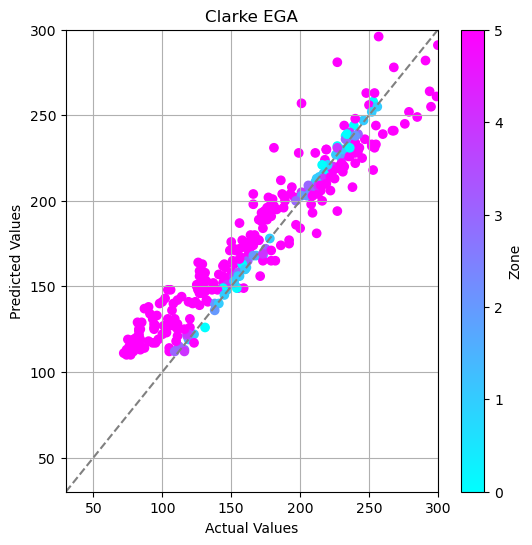

In [36]:
import matplotlib.pyplot as plt

# 生成示例数据，实际观测值和预测值
actual_values = true_value
predicted_values = pred_value

# 计算Clarke EGA图中的区域
def clarke_ega_region(actual, predicted):
    abs_diff = np.abs(predicted - actual)
    zones = np.zeros_like(abs_diff, dtype=int)
    zones[(abs_diff <= 1)] = 1
    zones[(abs_diff <= 2) & (abs_diff >1)] = 2
    zones[(abs_diff <= 3) & (abs_diff > 2)] = 3
    zones[(abs_diff <= 4) & (abs_diff > 3)] = 4
    zones[(abs_diff > 5)] = 5
    return zones

zones = clarke_ega_region(actual_values, predicted_values)

# 绘制Clarke EGA图
plt.figure(figsize=(6, 6))
plt.scatter(actual_values, predicted_values, c=zones, cmap='cool', marker='o')
plt.plot([30,300], [30,300], color='gray', linestyle='--')
plt.xlim(30,300)
plt.ylim(30,300)
plt.title("Clarke EGA")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

plt.grid()
plt.colorbar(label="Zone")

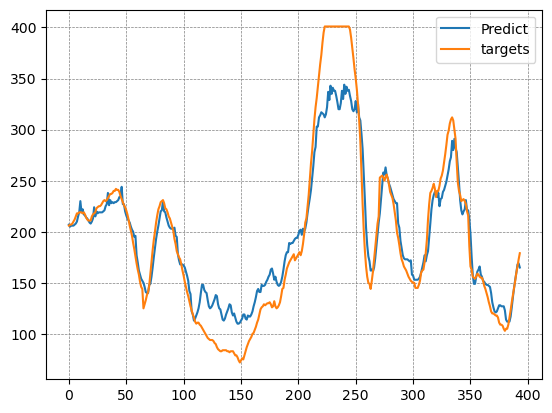

In [38]:
# 绘制predict 和 targets 的对比图
import matplotlib.pyplot as plt

plt.plot(pred_value, label="Predict")    # 预测值
plt.plot(true_value, label="targets")    # 真实值
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [39]:
# 想使用训练集的最后一个窗口预测训练集的下一个数据，再将窗口第一个数据弹出，将预测值插入窗口末尾组成一个新窗口。但是模型的输出是单个血糖值
# 缺了一些时间特征。要想实现真正的预测（有误差积累的预测）必须改变模型，使模型输出一个样本。
result = []
x = testX[0,:,:].unsqueeze(0).to(device)
print(x.shape)
for i in range(50):
    y = model(x)

    x = torch.cat((x[:,1:,:], y.unsqueeze(1)), dim=1)
    
    result.append(y.cpu().detach().numpy())

torch.Size([1, 48, 7])


(50, 1, 7)


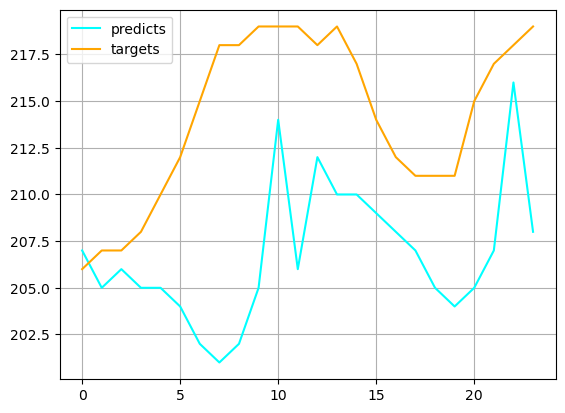

In [40]:
result = np.array(result)
print(result.shape)
pred_values = scaler.inverse_transform(result.reshape(-1,7))[:,-1].round()[:24]

true_values = testY[:50,:].numpy()
true_values = scaler.inverse_transform(true_values)[:,-1].round()[:24]

plt.plot(pred_values,color='cyan',label='predicts')
plt.plot(true_values,color='orange', label='targets')
plt.legend()
plt.grid()
plt.show()